In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation, parall_accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
from scipy.stats.distributions import chi2
import time
from scipy.stats.mstats import mquantiles
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import cpuinfo

In [23]:
def lrts_comp(data):
    n = 0
    biggets_p = -1*np.infty
    comp_biggest = 0
    max_comp = 10
    if len(data) < max_comp:
        max_comp = len(data)
    for i in range (1, max_comp+1, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p > biggets_p:
            biggets_p = p
            comp_biggest = i
        n = comp_biggest
    return n

def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

def theoretical_quantile (data, n_comp):
    model = GaussianMixture(n_components=n_comp,random_state=0)
    model.fit(data)
    q = []
    x = []
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data) - np.min(data))/1000
    d = np.arange(np.min(data),np.max(data), step)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    return x, q
def quantile_mix(p, vals, q):
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return vals[ind]
def probability_mix(val, vals, q):
    ind = vals.index(min(vals, key=lambda x:abs(x-val)))
    return(q[ind])
def sum_dist(data, vals, q):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for p in percs:
        y.append(quantile_mix(p/100, vals, q))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist


def component (data, columns, method):
    n = 1
    max_comp = 10
    x = []
    if data.shape[0] < max_comp:
        max_comp = data.shape[0]
    if len(columns) == 1:
        x = np.transpose([data[columns[0]].values])
    else:
        x = data[columns].values
    if method == 'aic':
        lowest_aic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            aic1 = gm1.aic(x)
            if aic1 < lowest_aic:
                lowest_aic = aic1
                comp_lowest = i
            n = comp_lowest


    if method == 'bic':
        lowest_bic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            bic1 = gm1.bic(x)
            if bic1 < lowest_bic:
                lowest_bic = bic1
                comp_lowest = i
            n = comp_lowest


    if method == 'LRTS':
        n = lrts_comp(x)
    if method == 'quantile':
        biggest_p = -1*np.infty
        comp_biggest = 0
        for i in range(1, max_comp, 1):
            vals, q = theoretical_quantile(x, i)
            dist = sum_dist(x, vals, q)
            p = probability_mix(dist, vals, q)
            if p > biggest_p:
                biggest_p = p
                comp_biggest = i
        n = comp_biggest
    return n

## Эксперименты на AIC, BIC, LRTS и межквантильное расстояние

In [4]:
data = pd.read_csv('../data/mehra.csv')

In [5]:
data_plot = np.transpose([data['ssr'].values])

In [6]:
ll = []
bic = []
aic = []
for i in range(1,11,1):
    gm = GaussianMixture(n_components=i, random_state=0)
    gm.fit(data_plot)
    ll_current = gm.lower_bound_
    bic_current = gm.bic(data_plot)
    aic_current = gm.aic(data_plot)
    ll.append(ll_current)
    bic.append(bic_current)
    aic.append(aic_current)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'BIC')

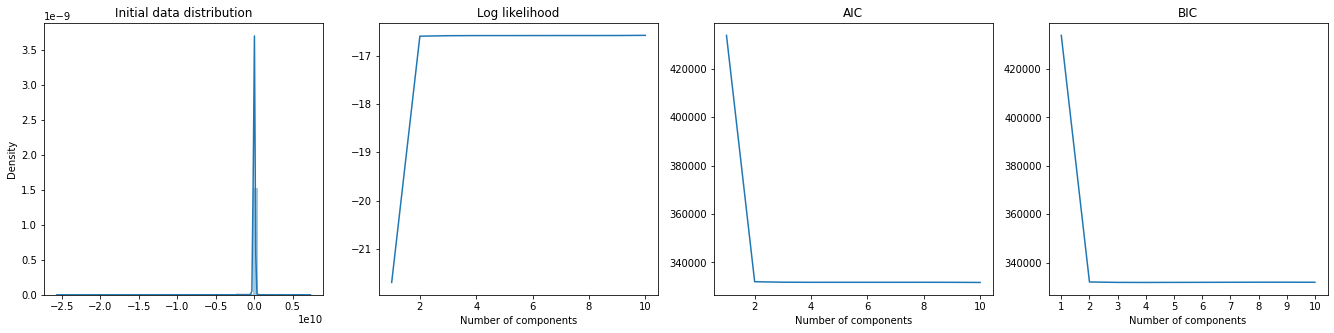

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(1,11,1)], aic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[2].set_xlabel('Number of components')
axes[2].set_title('AIC')

axes[3].plot([i for i in range(1,11,1)], bic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[3].set_xlabel('Number of components')
axes[3].set_title('BIC')

In [8]:
def LRTS(data):
    n = 0
    p_val = []
    labels = []
    for i in range (1, 10, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        p_val.append(p)
        labels.append('('+str(i)+','+str(i+1)+')')
    return p_val, labels

In [9]:
def lrts_comp(data):
    n = 0
    biggets_p = -1*np.infty
    comp_biggest = 0
    for i in range (1, 10, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p > biggets_p:
            biggets_p = p
            comp_biggest = i
        n = comp_biggest
    
    return n

In [10]:
p, label = LRTS(data_plot)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'p_values of LRTS')

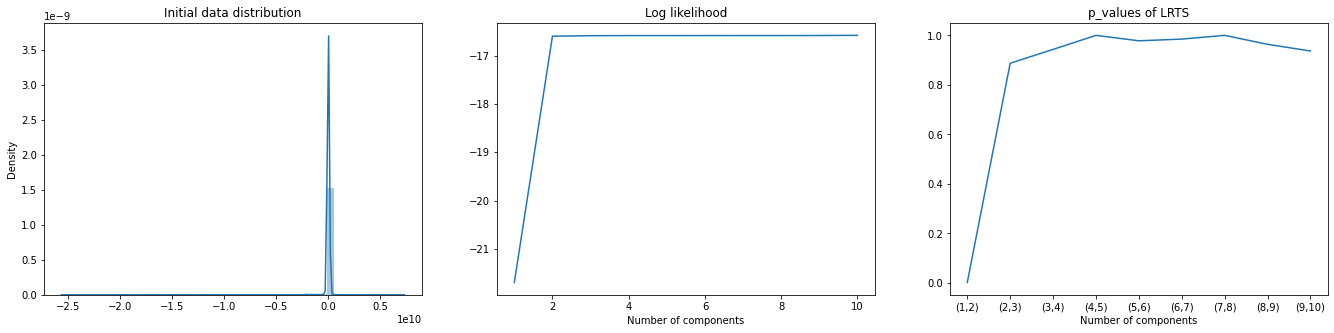

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(len(p))], p)
plt.xticks([i for i in range (len(p)) ], label)
axes[2].set_xlabel('Number of components')
axes[2].set_title('p_values of LRTS')


In [12]:
def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

In [13]:
def theoretical_quantile (data, n_comp):
    model = GaussianMixture(n_components=n_comp,random_state=0)
    model.fit(data)
    q = []
    x = []
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data) - np.min(data))/1000
    d = np.arange(np.min(data),np.max(data), step)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    return x, q


In [14]:
def quantile_mix(p, vals, q):
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return vals[ind]

In [15]:
def probability_mix(val, vals, q):
    ind = vals.index(min(vals, key=lambda x:abs(x-val)))
    return(q[ind])

In [16]:
mcdf = [[] for i in range(3)]
x = [[] for i in range(3)]
n_comp = [1, 2, 3]
for j, n in enumerate(n_comp):
    model = GaussianMixture(n_components=n).fit(data_plot)
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data_plot) - np.min(data_plot))/1000
    d = np.arange(np.min(data_plot),np.max(data_plot), step)
    for i in d:
        mcdf[j].append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
        x[j].append(i)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mix cdf with 3 component')

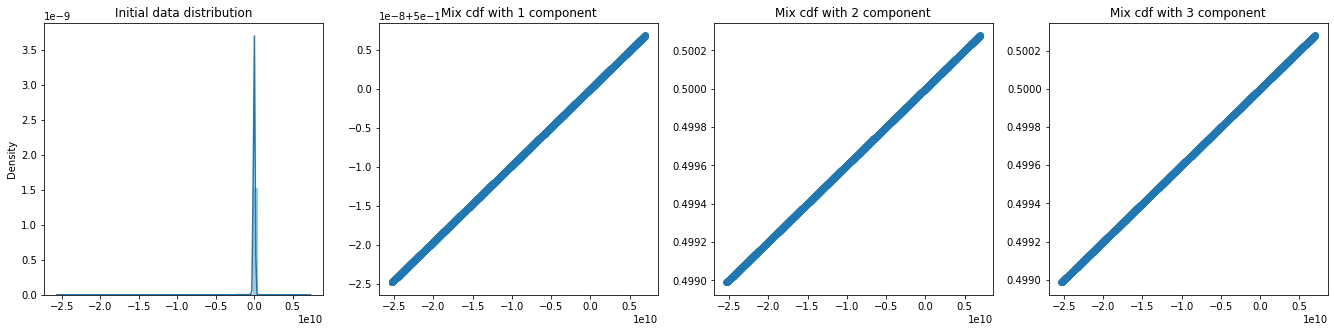

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].scatter(x[0], mcdf[0])
axes[1].set_title('Mix cdf with 1 component')

axes[2].scatter(x[1], mcdf[1])
axes[2].set_title('Mix cdf with 2 component')

axes[3].scatter(x[2], mcdf[2])
axes[3].set_title('Mix cdf with 3 component')

In [18]:
def sum_dist(data, vals, q):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for p in percs:
        y.append(quantile_mix(p/100, vals, q))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist

In [19]:
dists = []
for i in range (1, 11 ,1):
    vals, q = theoretical_quantile(data_plot, i)
    dists.append(sum_dist(data_plot, vals, q))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x2727ecda730>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

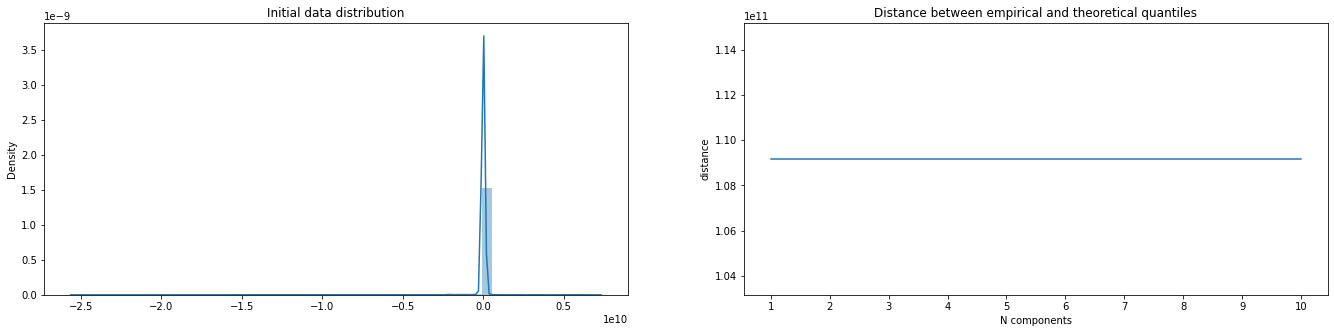

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

In [21]:
p_val = []
for i in range(10):
    vals, q = theoretical_quantile(data_plot, i+1)
    p_val.append(probability_mix(dists[i], vals, q))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x2727ee53d60>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

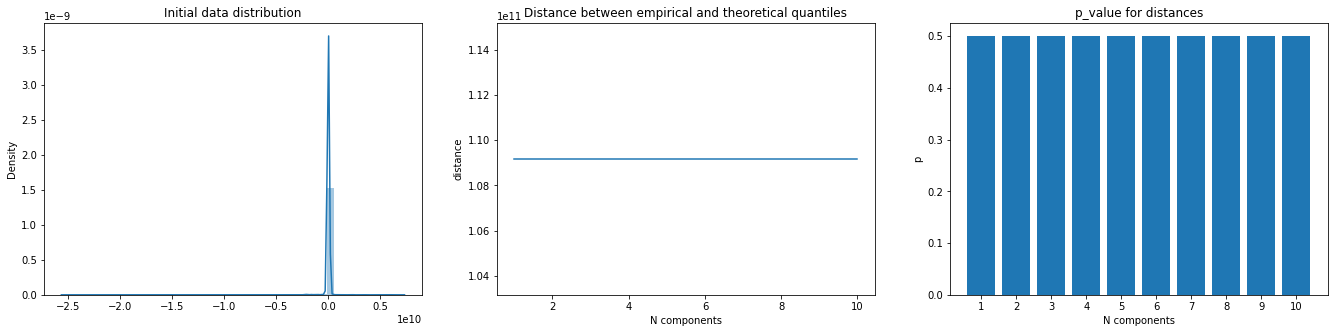

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])


axes[2].bar([i for i in range(1,11,1)], p_val)
axes[2].set_title('p_value for distances')
axes[2].set_xlabel('N components')
axes[2].set_ylabel('p')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

## Сравнение методов по времени

In [24]:
data = pd.read_csv('../data/mehra.csv')
data

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,Yorkshire and The Humber,West Midlands Urban Area,Background Urban,1988,Winter,3,26,9,52.829361,-1.726818,...,0.000784,992.501830,5.133717e+05,0.205020,61.974631,17.740408,13.813847,1.442624,36.486336,18.646589
1,North West,Greater London Urban Area,Background Rural,1995,Spring,8,2,19,51.377194,-2.745956,...,0.000130,1086.774403,1.149178e+07,0.246176,83.165539,32.657576,22.427120,1.273507,34.964375,18.643421
2,West Midlands,North West & Merseyside,Background Urban,1997,Spring,3,14,4,52.002869,-2.760588,...,0.000209,683.612000,-1.076695e+01,0.181319,76.460115,17.692036,13.803708,1.442563,36.458572,18.645740
3,South East,Greater London Urban Area,Traffic Urban,1994,Winter,3,3,18,54.061788,-2.439756,...,0.000996,1252.022401,3.290441e+06,0.201057,85.786023,17.749945,26.277995,1.793299,36.543445,18.641970
4,South East,Greater London Urban Area,Background Urban,1997,Fall,8,15,18,54.570412,-1.460727,...,-0.000691,1730.349463,8.348839e+06,0.175219,48.424476,83.015267,-0.018112,0.359330,38.317914,18.640665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Yorkshire and The Humber,North West & Merseyside,Background Urban,1993,Spring,7,3,0,51.502964,0.300996,...,0.003594,193.882528,4.162147e+06,0.175375,76.300697,17.760820,13.802362,1.442467,36.448082,18.639546
9996,Greater London Authority,Eastern,Traffic Urban,1997,Winter,4,27,3,52.740712,-0.547268,...,0.001259,28.284668,-2.723962e+05,0.282495,-97.144486,17.749629,13.818443,1.385102,36.086071,18.642884
9997,East Midlands,Greater London Urban Area,Traffic Urban,1985,Summer,7,4,23,53.554519,-1.734243,...,0.002055,407.258881,1.815961e+06,0.134340,78.544941,17.735576,13.808181,1.442177,36.476172,18.645422
9998,Yorkshire and The Humber,West Midlands,Background Urban,1990,Fall,10,20,20,51.180594,0.098250,...,0.000620,35.156433,1.742372e+06,0.219353,76.320929,17.742210,13.792902,1.442187,36.480802,18.642345


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='co'>

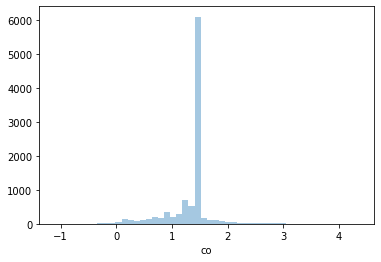

In [28]:
sns.distplot(data['co'], kde=False)

In [29]:
component(data, ['co'], 'aic')

10

In [30]:
component(data, ['co'], 'bic')

10

In [31]:
component(data, ['co'], 'LRTS')

2

In [32]:
component(data, ['co'], 'quantile')

3

In [35]:
node_types = get_nodes_type(data)
cont_columns = []
for key in node_types.keys():
    if node_types[key] == 'cont':
        cont_columns.append(key)

In [33]:
methods = ['aic', 'bic', 'LRTS', 'quantile']

In [36]:
metric = [[] for i in range(4)]
for c in cont_columns:
    for ind, m in enumerate(methods):
        start = time.time()
        n = component(data,[c], m)
        end = time.time()
        metric[ind].append((end-start)/n)

Text(0, 0.5, 'Time / Number of components')

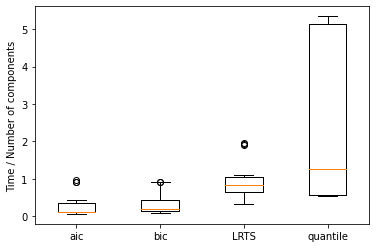

In [37]:
plt.boxplot(metric)
plt.xticks([(i+1) for i in range (4) ], methods)
plt.ylabel('Time / Number of components')

## Sample size эксперименты по нахождению зависимости

In [141]:
b08 = [[3, 5, 2, 2, 2, 2, 6, 2, 4, 4], [9, 15, 17, 9, 10, 11, 8, 11, 6, 7], [12, 20, 16, 12, 19, 14, 13, 20, 19, 19], [23, 16, 18, 32, 18, 24, 19, 19, 21, 19], [33, 38, 23, 29, 21, 37, 33, 31, 36, 32], [38, 37, 35, 42, 43, 42, 27, 30, 36, 39], [39, 46, 49, 38, 41, 38, 45, 44, 53, 47], [60, 50, 56, 54, 38, 55, 50, 56, 64, 53], [65, 65, 56, 69, 48, 57, 73, 54, 72, 45], [69, 63, 82, 70, 64, 77, 57, 80, 81, 52]]
b085 = [[3, 4, 4, 2, 7, 4, 6, 4, 5, 7],
 [13, 10, 9, 14, 14, 13, 11, 12, 14, 17],
 [22, 12, 16, 18, 20, 20, 23, 21, 22, 13],
 [31, 22, 32, 26, 29, 25, 24, 24, 30, 29],
 [34, 34, 28, 41, 30, 20, 35, 54, 30, 37],
 [45, 55, 56, 40, 42, 41, 51, 38, 40, 39],
 [54, 58, 59, 58, 44, 40, 51, 57, 45, 60],
 [65, 43, 71, 60, 58, 53, 63, 66, 47, 63],
 [89, 86, 78, 70, 64, 69, 72, 62, 57, 60],
 [78, 86, 80, 90, 62, 73, 86, 66, 81, 77]]
b095 = [[2, 6, 3, 7, 7, 10, 13, 9, 8, 4],
 [12, 7, 13, 10, 8, 22, 19, 17, 20, 27],
 [23, 52, 36, 27, 52, 31, 42, 52, 39, 30],
 [72, 44, 44, 44, 71, 53, 55, 48, 46, 63],
 [37, 73, 57, 66, 55, 63, 81, 53, 84, 65],
 [76, 81, 94, 100, 70, 101, 101, 71, 89, 86],
 [99, 74, 104, 104, 126, 96, 127, 89, 120, 112],
 [126, 140, 118, 165, 147, 140, 136, 117, 125, 137],
 [155, 180, 130, 144, 149, 112, 149, 152, 106, 146],
 [177, 195, 193, 160, 198, 217, 126, 174, 202, 168]]

b099 = [[8, 4, 13, 11, 7, 28, 2, 16, 17, 26], [12, 43, 66, 29, 24, 50, 53, 64, 36, 60], [140, 118, 121, 110, 128, 139, 104, 116, 126, 137], [91, 135, 190, 153, 152, 186, 111, 188, 178, 180], [133, 212, 229, 287, 307, 53, 242, 193, 210, 209], [346, 350, 243, 366, 234, 288, 296, 185, 295, 348], [153, 351, 331, 328, 344, 343, 390, 385, 446, 262], [370, 424, 593, 462, 489, 463, 315, 209, 506, 415], [534, 583, 432, 626, 514, 651, 536, 503, 221, 604], [767, 457, 196, 604, 803, 556, 562, 688, 717, 642]]

In [142]:
b082d = [[14, 9, 6, 11, 8, 9, 10, 7, 8, 6], [14, 24, 22, 21, 17, 18, 23, 25, 19, 8], [34, 30, 26, 33, 33, 37, 29, 36, 36, 34], [49, 45, 48, 38, 48, 55, 40, 43, 45, 29], [70, 61, 39, 63, 52, 60, 44, 59, 54, 66], [91, 86, 74, 70, 80, 77, 69, 69, 69, 73], [101, 91, 92, 91, 89, 82, 86, 81, 81, 88], [113, 119, 117, 98, 93, 118, 76, 86, 106, 79], [124, 129, 101, 127, 128, 130, 134, 111, 117, 103], [138, 137, 143, 135, 144, 125, 103, 133, 149, 140]]
b0852d = [[7, 12, 18, 10, 10, 13, 8, 7, 9, 10], [26, 16, 22, 28, 15, 23, 22, 16, 31, 24], [37, 24, 31, 42, 33, 46, 38, 43, 42, 36], [49, 51, 64, 61, 63, 42, 45, 55, 53, 51], [57, 92, 72, 87, 60, 71, 81, 76, 74, 76], [74, 95, 96, 89, 78, 90, 96, 78, 99, 103], [121, 83, 115, 119, 105, 117, 104, 121, 92, 124], [122, 136, 136, 133, 135, 138, 129, 102, 128, 127], [123, 161, 169, 142, 145, 143, 163, 163, 139, 140], [184, 167, 186, 184, 180, 167, 163, 191, 163, 137]]
b0952d = [[24, 16, 18, 17, 17, 18, 11, 23, 17, 19], [75, 32, 77, 50, 60, 51, 45, 29, 65, 59], [102, 108, 93, 97, 106, 87, 94, 111, 101, 82], [138, 140, 113, 114, 166, 138, 102, 131, 116, 141], [181, 185, 162, 183, 173, 137, 153, 147, 192, 190], [240, 251, 195, 192, 254, 185, 273, 234, 151, 265], [229, 290, 269, 266, 235, 260, 293, 261, 286, 288], [305, 302, 349, 340, 277, 326, 317, 287, 300, 321], [316, 352, 433, 350, 386, 370, 321, 413, 404, 290], [452, 434, 457, 412, 456, 456, 473, 433, 455, 423]]
b0992d = [[32, 34, 48, 28, 26, 59, 61, 49, 64, 86],
 [180, 153, 245, 207, 213, 193, 129, 137, 201, 180],
 [416, 399, 262, 264, 323, 355, 320, 389, 311, 330],
 [429, 395, 440, 519, 415, 371, 585, 640, 432, 498],
 [641, 635, 749, 606, 691, 684, 657, 570, 746, 538],
 [694, 661, 752, 1130, 850, 849, 958, 878, 787, 759],
 [1229, 1126, 1013, 1199, 1108, 1127, 1031, 756, 1108, 941],
 [1182, 1330, 1065, 1063, 1304, 1162, 1266, 1200, 1299, 1434],
 [1410, 1713, 1405, 1925, 1291, 1530, 1637, 1351, 1470, 1510],
 [1639, 1632, 1639, 1747, 1662, 1805, 1669, 1950, 1509, 1795]]

In [143]:
b083d = [[14, 15, 13, 14, 20, 17, 25, 13, 15, 13], [37, 28, 31, 35, 44, 36, 35, 39, 45, 29], [43, 51, 56, 71, 74, 70, 56, 33, 61, 46], [77, 68, 78, 91, 68, 72, 75, 93, 72, 89], [98, 115, 98, 102, 136, 96, 101, 110, 111, 95], [141, 149, 127, 133, 117, 137, 109, 132, 126, 126], [153, 160, 150, 174, 140, 155, 158, 124, 152, 135], [164, 176, 195, 182, 200, 186, 189, 150, 180, 183], [219, 170, 181, 145, 207, 212, 213, 187, 214, 185], [219, 240, 242, 224, 250, 239, 229, 234, 212, 233]]
b0853d = [[18, 10, 22, 13, 15, 21, 13, 24, 17, 24], [49, 35, 37, 47, 55, 47, 50, 50, 40, 48], [60, 72, 87, 70, 71, 80, 77, 63, 83, 77], [106, 79, 98, 89, 106, 109, 88, 125, 81, 91], [119, 125, 122, 113, 115, 144, 131, 121, 117, 107], [201, 189, 162, 145, 161, 179, 133, 194, 177, 156], [232, 169, 164, 179, 208, 199, 196, 215, 186, 217], [256, 239, 218, 206, 172, 235, 199, 226, 200, 230], [257, 224, 213, 252, 229, 230, 269, 246, 260, 245], [316, 304, 320, 259, 324, 240, 224, 302, 276, 309]]
b0953d = [[34, 20, 28, 40, 30, 26, 41, 34, 37], [113, 93, 102, 114, 91, 116, 88, 112, 85], [177, 184, 188, 213, 148, 185, 195, 139, 173], [262, 279, 245, 248, 281, 267, 239, 253, 243], [289, 320, 278, 344, 357, 355, 385, 331, 286], [419, 425, 429, 408, 399, 460, 387, 367, 411], [463, 536, 589, 502, 513, 464, 493, 500, 482], [593, 574, 556, 599, 533, 571, 523, 558, 604], [646, 696, 585, 634, 678, 646, 599, 654], [738, 791, 708, 850, 620, 733, 739, 730]]
b0993d = [[143, 72, 128, 141, 172, 85, 149, 182, 114, 138],
 [312, 465, 356, 436, 331, 343, 371, 398, 395, 392],
 [689, 709, 699, 766, 410, 744, 826, 613, 535, 768],
 [1149, 1007, 910, 1119, 1158, 883, 1069, 1057, 1038, 951],
 [1416, 1163, 1505, 1247, 1158, 1342, 936, 1437, 1447, 1419],
 [1623, 1724, 1649, 1753, 1596, 1783, 1642, 1902, 1622, 1908],
 [1723, 2097, 2115, 1915, 2153, 2267, 2382, 1954, 2253, 2230],
 [2399, 2413, 2324, 2156, 2476, 2098, 1895, 2437, 2427, 2524],
 [2686, 3433, 2704, 2864, 2801, 2594, 2516, 2482, 2773, 2940],
 [2495, 2981, 3423, 2923, 3297, 3511, 2833, 3152, 2704, 2767]]

In [144]:
#1D визуализация
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0.8, 0.85, 0.95, 0.99]
x1 = [c for _ in range(4)]
y1 = []
for bi in b:
    one_point = []
    for _ in range(10):
       one_point.append(bi)
    y1.append(one_point)

res = [b08, b085, b095, b099]
z1 = []
for r in res:
    res_b = []
    for c in r:
        res_b.append(np.median(c))
    z1.append(res_b)
x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1)

In [145]:
#2D визуализация
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0.8, 0.85, 0.95, 0.99]
x2 = [c for _ in range(4)]
y2 = []
for bi in b:
    one_point = []
    for _ in range(10):
       one_point.append(bi)
    y2.append(one_point)

res = [b082d, b0852d, b0952d, b0992d]
z2 = []
for r in res:
    res_b = []
    for c in r:
        res_b.append(np.median(c))
    z2.append(res_b)
x2 = np.array(x2)
y2 = np.array(y2)
z2 = np.array(z2)

In [146]:
#3D визуализация
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [0.8, 0.85, 0.95, 0.99]
x3 = [c for _ in range(4)]
y3 = []
for bi in b:
    one_point = []
    for _ in range(10):
       one_point.append(bi)
    y3.append(one_point)

res = [b083d, b0853d, b0953d, b0993d]
z3 = []
for r in res:
    res_b = []
    for c in r:
        res_b.append(np.median(c))
    z3.append(res_b)
x3 = np.array(x3)
y3 = np.array(y3)
z3 = np.array(z3)

Text(0.5, 0, 'sample size')

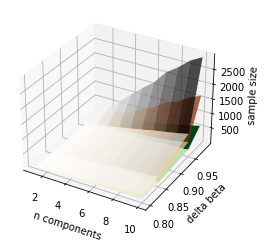

In [159]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x1, y1, z1,  cmap='Greens', label='1D')
ax.plot_surface(x2, y2, z2, cmap='Oranges', alpha=0.7, label='2D')
ax.plot_surface(x3, y3, z3, cmap='Greys', alpha=0.7, label='3D')
ax.set_xlabel('n components')
ax.set_ylabel('delta beta')
ax.set_zlabel('sample size')


In [238]:
#Изменение Sample size для каждой компоненты в зависимости от ndim
z = [list(z1[3]), list(z2[3]), list(z3[3])]
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1, 2, 3]
x = [c for _ in range(3)]
y = []
for bi in b:
    one_point = []
    for _ in range(10):
       one_point.append(bi)
    y.append(one_point)
x = np.array(x)
y = np.array(y)
z = np.array(z)

Text(0.5, 0, 'sample size')

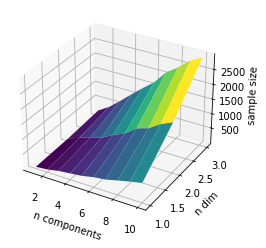

In [220]:
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
ax.set_xlabel('n components')
ax.set_ylabel('n dim')
ax.set_zlabel('sample size')

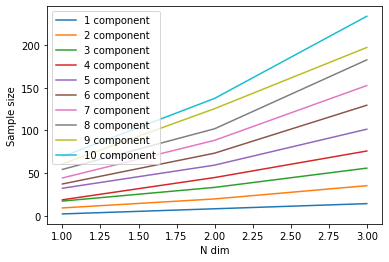

In [234]:
plt.plot([1, 2, 3], [z1[0][0], z2[0][0], z3[0][0]], label='1 component')
plt.plot([1, 2, 3], [z1[0][1], z2[0][1], z3[0][1]], label='2 component')
plt.plot([1, 2, 3], [z1[0][2], z2[0][2], z3[0][2]], label='3 component')
plt.plot([1, 2, 3], [z1[0][3], z2[0][3], z3[0][3]], label='4 component')
plt.plot([1, 2, 3], [z1[0][4], z2[0][4], z3[0][4]], label='5 component')
plt.plot([1, 2, 3], [z1[0][5], z2[0][5], z3[0][5]], label='6 component')
plt.plot([1, 2, 3], [z1[0][6], z2[0][6], z3[0][6]], label='7 component')
plt.plot([1, 2, 3], [z1[0][7], z2[0][7], z3[0][7]], label='8 component')
plt.plot([1, 2, 3], [z1[0][8], z2[0][8], z3[0][8]], label='9 component')
plt.plot([1, 2, 3], [z1[0][9], z2[0][9], z3[0][9]], label='10 component')
plt.xlabel('N dim')
plt.ylabel('Sample size')
plt.legend()

In [247]:
coef08 = []
intercept08 = []
X = [1, 2, 3]
for i in range(10):
    model = LinearRegression()
    model.fit(np.transpose([X]), [z1[0][i], z2[0][i], z3[0][i]])
    coef08.append(model.coef_)
    intercept08.append(model.intercept_)

In [248]:
coef095 = []
intercept095 = []
X = [1, 2, 3]
for i in range(10):
    model = LinearRegression()
    model.fit(np.transpose([X]), [z1[2][i], z2[2][i], z3[2][i]])
    coef095.append(model.coef_)
    intercept095.append(model.intercept_)

In [333]:
intercept095

[-7.499999999999993,
 -29.66666666666662,
 -39.666666666666615,
 -56.49999999999994,
 -76.33333333333329,
 -78.33333333333329,
 -105.49999999999989,
 -94.99999999999994,
 -113.66666666666663,
 -92.49999999999977]

In [332]:
for c in coef095:
    print(round(c[0], 2))

13.5
43.5
73.25
101.25
133.5
161.75
198.0
217.25
249.25
275.25


In [249]:
coef099 = []
intercept099 = []
X = [1, 2, 3]
for i in range(10):
    model = LinearRegression()
    model.fit(np.transpose([X]), [z1[3][i], z2[3][i], z3[3][i]])
    coef099.append(model.coef_)
    intercept099.append(model.intercept_)

In [327]:
Zpred08 = []
for j in range(10):
    Zpred08.append(12*coef08[j][0] + intercept08[j])
Zpred095 = []
for j in range(10):
    Zpred095.append(12*coef095[j][0] + intercept095[j])
Zpred099 = []
for j in range(10):
    Zpred099.append(12*coef099[j][0] + intercept099[j])

In [328]:
m08 = LinearRegression().fit(np.transpose([Zpred08]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
m095 = LinearRegression().fit(np.transpose([Zpred095]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
m099 = LinearRegression().fit(np.transpose([Zpred099]), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [329]:
print(round(m08.predict([[data.shape[0]]])[0]))
print(round(m095.predict([[data.shape[0]]])[0]))
print(round(m099.predict([[data.shape[0]]])[0]))

1
1
1


In [240]:
Zpred = []
ypred = []
xpred = [c for _ in range(10)]
bpred = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for bi in bpred:
    one_point = []
    for _ in range(10):
       one_point.append(bi)
    ypred.append(one_point)
for i in range(10):
    z_fid = []
    for j in range(10):
        z_fid.append((i+1)*coef[j][0] + intercept[j])
    Zpred.append(z_fid)

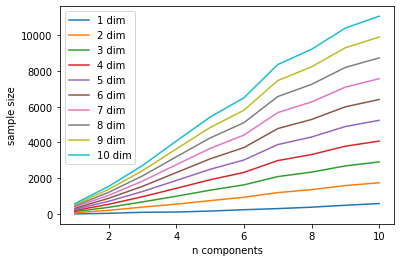

In [246]:
for ind, zi in enumerate(Zpred):
    plt.plot(xpred[0], zi, label=str(ind+1) + ' dim')
plt.xlabel('n components')
plt.ylabel('sample size')
plt.legend()

Text(0.5, 0, 'sample size')

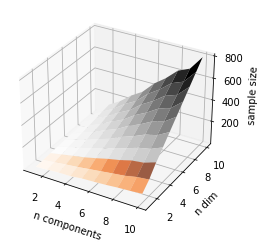

In [237]:
Zpred = np.array(Zpred)
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap='Oranges', edgecolor='none', alpha=0.7)
ax.plot_surface(xpred, ypred, Zpred, cmap='Greys', edgecolor='none')
ax.set_xlabel('n components')
ax.set_ylabel('n dim')
ax.set_zlabel('sample size')

In [128]:
df = pd.DataFrame(columns=['delta beta', 'n components', 'sample size'])
for xi, yi, zi in zip(x, y, z):
    for i, j, k in zip(xi, yi, zi):
        df = df.append({'delta beta': j, 'n components': i, 'sample size': k}, ignore_index=True)

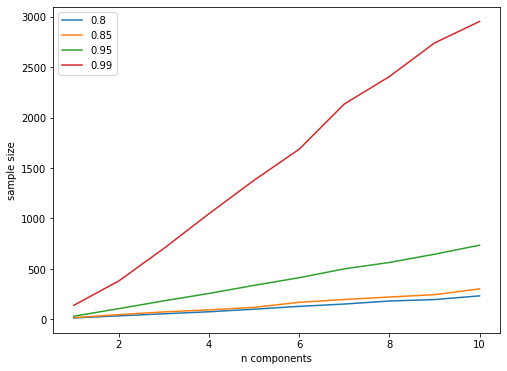

In [129]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df_p in df.groupby('delta beta'):
    plt.plot(df_p['n components'], df_p['sample size'], label=label)
plt.xlabel('n components')
plt.ylabel('sample size')
plt.legend()


In [ ]:
n_dim = [1, 2, 3]
plt.plot(n_dim, [z1[2][0]])